In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [9]:
import os
os.chdir('/content/drive/MyDrive/Projects/reddit-vote-predictor')
import sys
if 'psaw' not in sys.modules:
  print('Installing psaw')
  os.system('pip install psaw')
import shutil as sh
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats as s
from skimage import io
from mpl_toolkits.axes_grid1 import ImageGrid
import datetime as dt

Installing psaw


# Read in the data


In [3]:
# Cats
cat = pd.read_csv('data/tbl/cat_posts.csv', index_col='id')
# and dogs
dog = pd.read_csv('data/tbl/dog_posts.csv', index_col='id')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (3,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [18]:
dog['created_date'] = pd.to_datetime(dog['created']) dog

Timestamp('1970-01-01 00:00:01.295931812')

## Some preliminary filters
1. We need images, so filter for `post_hint == 'image'`
2. We don't want to use `pinned` posts, as votes could be inflated.
     * Note, this appears not to ever be the case in these subreddits
3.   We want to use retrieved and created dates to attempt to use posts for
which we have a `score` that reflects a time-window of "voting" that is cosistent across posts. 
    * We also want to z-score this before modeling
4. Relatedly, subreddit subscribers shows ththe number of subscribers at the 
`retreived on` date (can be verified using `subredditstats.com`)
5. To-do: check to see if the author is too popular.
    * Possibly filter out some authors whose posts are on in general voted higher or lower than average





In [4]:
cat_fltr = cat[(~cat.pinned) & (cat.post_hint == 'image')].sort_values('score', ascending = False)
dog_fltr = dog[(~dog.pinned) & (dog.post_hint == 'image')].sort_values('score', ascending = False)

TypeError: ignored

# What do the top cats and dogs look like?

In [ ]:
# Extract the URL to the top-ranked posts for each dataset
top_cats = cat_fltr.url.values[0:9]
top_dogs = dog_fltr.url.values[0:9]
print(top_cats)
top_dogs

['https://i.redd.it/76oddj1nw7481.jpg'
 'https://i.redd.it/v25js77o2zj61.jpg'
 'https://i.redd.it/3k7vxfofcpe61.jpg'
 'https://i.redd.it/1rd0w6owp4k61.jpg'
 'https://i.redd.it/xgumdh8jkjj61.jpg'
 'https://i.redd.it/7760qffhx1f61.jpg'
 'https://i.redd.it/zx1t74rjtuj61.jpg'
 'https://i.redd.it/ifwb7kh16qj61.jpg'
 'https://i.redd.it/b9kfwpy7cyk61.jpg']


array(['https://i.redd.it/azjwhj0jdda61.jpg',
       'https://i.redd.it/0z2jl8g62kj61.jpg',
       'https://i.redd.it/0rqdelr2q9j61.jpg',
       'https://i.redd.it/4stng8r3ivk61.jpg',
       'https://i.redd.it/uqdypisw43l61.jpg',
       'https://i.redd.it/c3cxvrzdtoe61.jpg',
       'https://i.redd.it/r5nxplzd2yj61.jpg',
       'https://i.redd.it/ue0tfwq137481.jpg',
       'https://i.redd.it/1r9x5ak71hj61.jpg'], dtype=object)

We'll use the thumbnails for the following reasons


*   The files are smaller
*   The files are in more uniform dimensions
*   The files are more likely to have already centered the cat or dog (usually)

Possible improvements: use YOLO to detect the cat or dog, and crop uniformly around the bounding box, centering the cat or dog. Sometimes, the cat or dog is obstructed in the thumbnail. This may not have mattered for voting, but in order for the model to learn aspects of cats or dogs specifically that lead to higher or lower votes, the model may not be able to make use of some thumbs

In [ ]:
# with the thumbnail instead
top_cats_thumb = cat_fltr.thumbnail.values[0:9]
top_dogs_thumb = dog_fltr.thumbnail.values[0:9]

In [ ]:
# Using an ImageGrid method
def plot_top9(data):
  """
  Data is the scraped data. Since some images might have been taken down, use 
  try-except to plot the top 9 images that exist
  """
  thumb_urls = data.sort_values('score', ascending = False).thumbnail.values
  im_list = []
  i = 0
  while len(im_list) < 9:
    thumb = thumb_urls[i]
    try:
      im = io.imread(thumb)
      im_list.append(im)
      
    except:
      pass
    i += 1
  
  # set up the 3 by 3 grid for plotting
  fig = plt.figure(figsize=(9., 9.))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                   nrows_ncols=(3, 3),  # creates 1x2 grid of axes
                   axes_pad=0.1,  # pad between axes in inch.
                   )

  for ax, im_ in zip(grid, im_list):
      # Iterating over the grid returns the Axes.
      ax.imshow(im_)

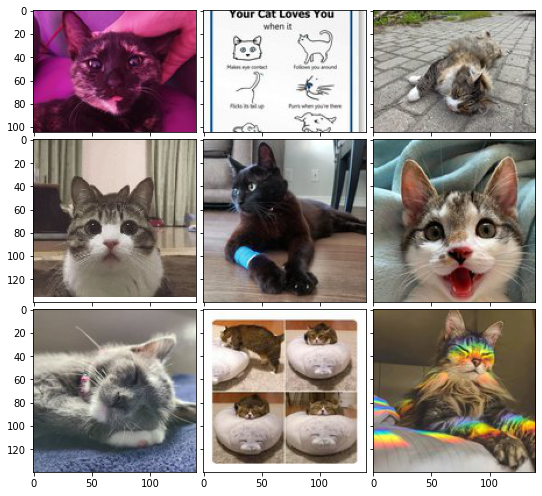

In [ ]:
# Images of top cats
plot_top9(cat_fltr)

found https://b.thumbs.redditmedia.com/BirW-xFsNtXOlyhTdgg8Gt6fkgh20G0Hx0RaKfo3dAs.jpg
found https://b.thumbs.redditmedia.com/vGaVJ2WmqmIsEB3AVvUiC5JCf0C5tMY3fobL2S_7Rwk.jpg
found https://b.thumbs.redditmedia.com/THC1FfowkqbzEMc7w9TieyHh_U9IFFIkNY0JgZvdMgc.jpg
found https://b.thumbs.redditmedia.com/1nlzUSs1rOzkiQNTOoHcTPJrSWFoS9AEbLcjzU74diA.jpg
found https://b.thumbs.redditmedia.com/OfVg-Xa5DGFJX3ObM4wHybM5dUVmQA9wXa1pij2jvXQ.jpg
found https://b.thumbs.redditmedia.com/t41X63sqdL6ANvcH7rZaQtNDpg2I_HN0EhuGsgudRhw.jpg
found https://b.thumbs.redditmedia.com/Fn-WhAW-BxlevDaNscJq6Iw1ibXpYTKiR9fuTN5OooE.jpg
found https://b.thumbs.redditmedia.com/3L3sM4byiOkLmLHKOSXEE_3yOakpUU3Bo0-nPZt-5rM.jpg
found https://b.thumbs.redditmedia.com/45Q4knOZXu--fDOHp6l3wQ0vy7nPjA35b_fvY1d94Kk.jpg


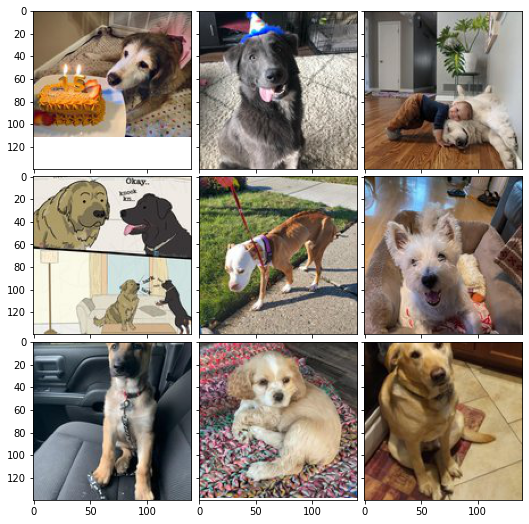

In [ ]:
# Images of top dogs
plot_top9(dog_fltr)

### Continue filtering the data according to the below:


1.   Delete images that have a score of `1`. This is because Reddit automatically upvotes initial posts. Given only the `score` it's impossible to know if any users have evaluated an image with a `score` of 1 at all (e.g., 12 upvoting and 11 downvoting resulting in a `score` of 1) or if it simply has a score of `1` since it was posted.
2.   Then sample uniformly from quantiles of `score` to give the model ample variability from which to learn (without `1`-inflation)



In [ ]:
cat_fltr = cat_fltr[cat_fltr.score != 1]
dog_fltr = dog_fltr[dog_fltr.score != 1]

In [ ]:

# labels = ['q1', 'q2', 'q3', 'q4']
# cat_fltr['quantile'] = pd.qcut(cat_fltr.score, q = 4, labels = labels)
# cat_fltr = pd.concat([cat_fltr[cat_fltr['quantile'].eq(label)].sample(1) for label in labels])
# dog_fltr['quantile'] = pd.qcut(dog_fltr.score, q = 4, labels = labels)
# out = pd.concat([df[df['quantile'].eq(label)].sample(1) for label in labels])
# Create a new column with the quantile label/factor
labels = ['q1', 'q2', 'q3', 'q4']
cat_fltr['quantile'] = pd.qcut(cat_fltr.score, q = 4, labels = labels)
cat_q_min = cat_fltr.value_counts('quantile').min()
dog_fltr['quantile'] = pd.qcut(dog_fltr.score, q = 4,labels = labels)
dog_q_min = dog_fltr.value_counts('quantile').min()
# downsample to the minimum quantile for each
cat_df = pd.concat([cat_fltr[cat_fltr['quantile'].eq(label)].sample(cat_q_min) for label in labels])
dog_df = pd.concat([dog_fltr[dog_fltr['quantile'].eq(label)].sample(dog_q_min) for label in labels])
# Sanity checks
print('Min cat quantile size:', cat_q_min, '\nValue counts: ', cat_df.value_counts('quantile').values) 
print('Min dog quantile size:', dog_q_min, '\nValue counts: ', dog_df.value_counts('quantile').values) 

Min cat quantile size: 288 
Value counts:  [288 288 288 288]
Min dog quantile size: 185 
Value counts:  [185 185 185 185]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# Does this leave us with enough data?
print(cat_df.shape)
dog_df.shape

(1152, 16)


(740, 16)

### some conclusions at this stage
One year of cat data, filtered, provided us with 1152 images, and for dogs 740 images. Let's instead pull data from more years to build a bigger final dataset

To do so, make edits to scraping script and re-run the above steps.